In [205]:
#!/usr/bin/env python3

##### Datasegments description

Based on two datasets, we can identify sort of information.

- id - identifier
- segment_id - segment identifier
- tine_index - timestamp of hour aggregation
- devices - on which devices these views were generated

Dataset Description
|segment_id   |  segment_name |
|---|---|
|00052 |Travel   |
|00053 |Style & Fashion   |
|00058   |Shopping   |
|00077   |Pets   |
|00090   |Sports   |
|00150   |Science   |
|00176   |Religion & Spirituality   |
|00210   |Sensitive Topics   |
|00274   |Music   |
|00279   |Food & Drink   |
|00379   |Technology & Computing   |
|00483   |Books and Literature   |
|00492   |Real Estate   |

##### Libraries to use

In [206]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import json
import seaborn as sns
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot


dataPoints = pd.read_csv('datapoints-ssp-mock2.csv')
segments = pd.read_csv('segments-ssp-mock2.csv')

In [207]:
dataPoints.head()

,id,segment_id,time_index,view_count,devices
0,1,379,2022-01-01 00:00:00,177,"{""windows"": 120, ""android"": 7, ""mac os x"": 37,..."
1,2,379,2022-01-01 01:00:00,135,"{""windows"": 92, ""android"": 5, ""mac os x"": 28, ..."
2,3,379,2022-01-01 02:00:00,26,"{""windows"": 18, ""android"": 1, ""mac os x"": 5, ""..."
3,4,379,2022-01-01 03:00:00,159,"{""windows"": 108, ""android"": 6, ""mac os x"": 33,..."
4,5,379,2022-01-01 04:00:00,50,"{""windows"": 34, ""android"": 2, ""mac os x"": 10, ..."


In [208]:
segments.head()

,segment_id,segment_name
0,52,Travel
1,53,Style & Fashion
2,58,Shopping
3,77,Pets
4,90,Sports


In [209]:
# checks null values
dataPoints.isnull().values.any()

False

In [210]:
# indexed dataPoints
indexed_dataPoints = dataPoints.set_index('id')
indexed_dataPoints.head()

,segment_id,time_index,view_count,devices
id,,,,
1,379,2022-01-01 00:00:00,177,"{""windows"": 120, ""android"": 7, ""mac os x"": 37,..."
2,379,2022-01-01 01:00:00,135,"{""windows"": 92, ""android"": 5, ""mac os x"": 28, ..."
3,379,2022-01-01 02:00:00,26,"{""windows"": 18, ""android"": 1, ""mac os x"": 5, ""..."
4,379,2022-01-01 03:00:00,159,"{""windows"": 108, ""android"": 6, ""mac os x"": 33,..."
5,379,2022-01-01 04:00:00,50,"{""windows"": 34, ""android"": 2, ""mac os x"": 10, ..."


In [211]:
indexed_dataPoints.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95526 entries, 1 to 95526
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   segment_id  95526 non-null  int64 
 1   time_index  95526 non-null  object
 2   view_count  95526 non-null  int64 
 3   devices     95526 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.6+ MB


In [212]:
indexed_dataPoints['devices'] = indexed_dataPoints['devices'].apply(json.loads)

# new DataFrame with individual device columns
devices_df = pd.DataFrame(indexed_dataPoints['devices'].tolist(), index=indexed_dataPoints.index)

# new device DataFrame with the original main_dataset
new_dataset = pd.concat([indexed_dataPoints[['segment_id', 'time_index', 'view_count']], devices_df], axis=1)



In [213]:
new_dataset

,segment_id,time_index,view_count,windows,android,mac os x,iphone,other
id,,,,,,,,
1,379,2022-01-01 00:00:00,177,120,7,37,9,2
2,379,2022-01-01 01:00:00,135,92,5,28,7,1
3,379,2022-01-01 02:00:00,26,18,1,5,1,0
4,379,2022-01-01 03:00:00,159,108,6,33,8,2
5,379,2022-01-01 04:00:00,50,34,2,10,2,0
...,...,...,...,...,...,...,...,...
95522,77,2022-11-27 01:00:00,240,110,12,94,19,5
95523,77,2022-11-27 02:00:00,242,111,12,94,19,5
95524,77,2022-11-27 03:00:00,207,95,10,81,17,4


In [214]:
# merged with segments dataset
final_dataset = pd.merge(new_dataset, segments, on='segment_id', how='left')

final_dataset.rename(columns={'time_index': 'date'},inplace=True)
final_dataset.head()

,segment_id,date,view_count,windows,android,mac os x,iphone,other,segment_name
0,379,2022-01-01 00:00:00,177,120,7,37,9,2,Technology & Computing
1,379,2022-01-01 01:00:00,135,92,5,28,7,1,Technology & Computing
2,379,2022-01-01 02:00:00,26,18,1,5,1,0,Technology & Computing
3,379,2022-01-01 03:00:00,159,108,6,33,8,2,Technology & Computing
4,379,2022-01-01 04:00:00,50,34,2,10,2,0,Technology & Computing


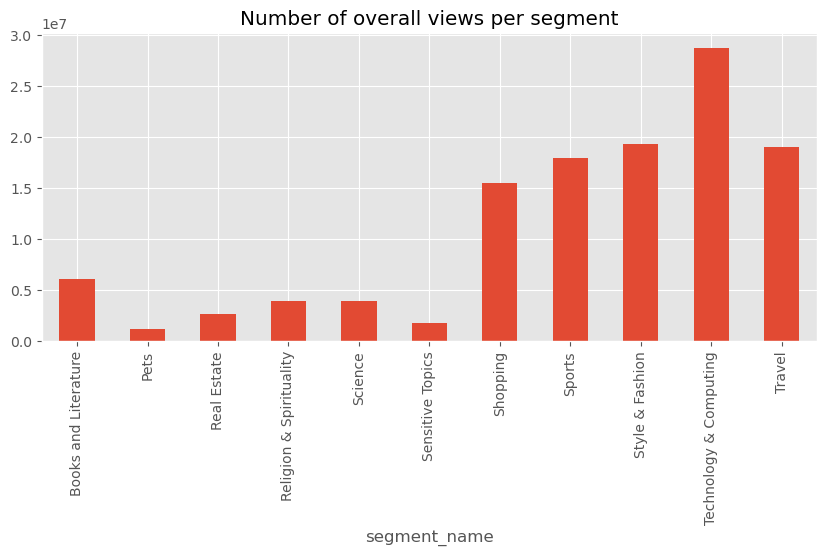

In [215]:
nb_views_per_segment = final_dataset.groupby('segment_name')['view_count'].sum()
nb_views_per_segment.plot(kind='bar', title='Number of overall views per segment')
plt.show()

In [216]:
final_dataset.pivot_table(values='view_count', index='segment_name', aggfunc=[np.mean, np.median, np.sum]) 
# most of views are connected to technology & computing, style & fashion and travel

,mean,median,sum
,view_count,view_count,view_count
segment_name,,,
Books and Literature,693.987671,650.5,6079332
Pets,148.435024,125.0,1176496
Real Estate,305.111872,280.0,2672780
Religion & Spirituality,445.540411,408.0,3902934
Science,446.420890,414.0,3910647
Sensitive Topics,203.652283,184.0,1783994
Shopping,1769.963356,1645.0,15504879
Sports,2048.963128,1922.5,17948917


In [217]:
final_dataset.view_count.describe()

count    95526.000000
mean      1257.967527
std       1504.672021
min          0.000000
25%        227.000000
50%        615.000000
75%       1955.000000
max      15963.000000
Name: view_count, dtype: float64

In [218]:
final_dataset.groupby('segment_name')['view_count'].sum()

segment_name
Books and Literature        6079332
Pets                        1176496
Real Estate                 2672780
Religion & Spirituality     3902934
Science                     3910647
Sensitive Topics            1783994
Shopping                   15504879
Sports                     17948917
Style & Fashion            19358950
Technology & Computing     28744214
Travel                     19085463
Name: view_count, dtype: int64

In [219]:
final_dataset.head()

,segment_id,date,view_count,windows,android,mac os x,iphone,other,segment_name
0,379,2022-01-01 00:00:00,177,120,7,37,9,2,Technology & Computing
1,379,2022-01-01 01:00:00,135,92,5,28,7,1,Technology & Computing
2,379,2022-01-01 02:00:00,26,18,1,5,1,0,Technology & Computing
3,379,2022-01-01 03:00:00,159,108,6,33,8,2,Technology & Computing
4,379,2022-01-01 04:00:00,50,34,2,10,2,0,Technology & Computing


In [220]:
final_dataset['date'] = pd.to_datetime(final_dataset['date'])

In [221]:
final_dataset['day_of_week'] = final_dataset['date'].dt.day_of_week
final_dataset['day_of_month'] = final_dataset['date'].dt.day
final_dataset['month'] = final_dataset['date'].dt.month
final_dataset['hour'] = final_dataset['date'].dt.hour

final_dataset.sample(5)

,segment_id,date,view_count,windows,android,mac os x,iphone,other,segment_name,day_of_week,day_of_month,month,hour
94994,77,2022-11-05 02:00:00,204,94,10,80,16,4,Pets,5,5,11,2
86089,492,2022-10-30 01:00:00,448,269,22,121,27,9,Real Estate,6,30,10,1
18954,53,2022-03-01 18:00:00,748,509,30,157,37,7,Style & Fashion,1,1,3,18
25803,53,2022-12-12 03:00:00,4322,2939,173,908,216,43,Style & Fashion,0,12,12,3
39407,58,2022-07-01 23:00:00,2181,1570,65,414,87,22,Shopping,4,1,7,23


In [222]:
final_dataset.set_index('date', inplace=True) #  setting index as time_index
final_dataset.head()

,segment_id,view_count,windows,android,mac os x,iphone,other,segment_name,day_of_week,day_of_month,month,hour
date,,,,,,,,,,,,
2022-01-01 00:00:00,379,177,120,7,37,9,2,Technology & Computing,5,1,1,0
2022-01-01 01:00:00,379,135,92,5,28,7,1,Technology & Computing,5,1,1,1
2022-01-01 02:00:00,379,26,18,1,5,1,0,Technology & Computing,5,1,1,2
2022-01-01 03:00:00,379,159,108,6,33,8,2,Technology & Computing,5,1,1,3
2022-01-01 04:00:00,379,50,34,2,10,2,0,Technology & Computing,5,1,1,4


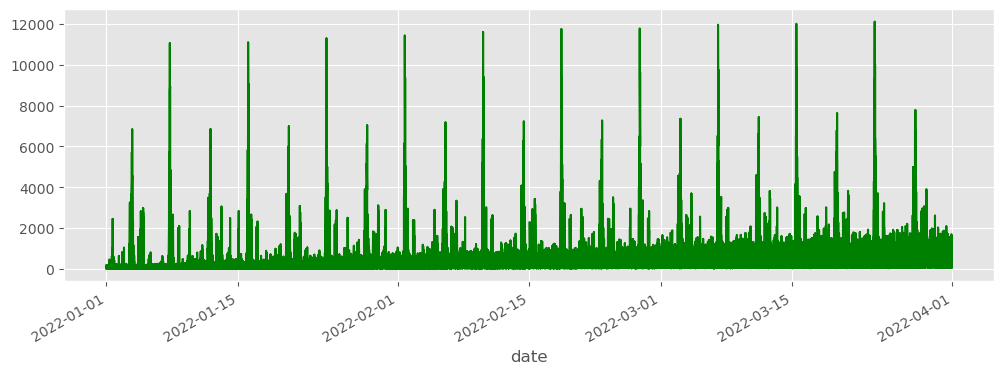

In [223]:
# choose period 
final_dataset['2022-01': '2022-03']['view_count'].plot(color='green', figsize=(12, 4))
plt.show()

/var/folders/q4/xxffn3rn1mq08t7xhtm9_fbw0000gn/T/ipykernel_5129/4117572050.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_df = final_dataset.resample('D').mean()


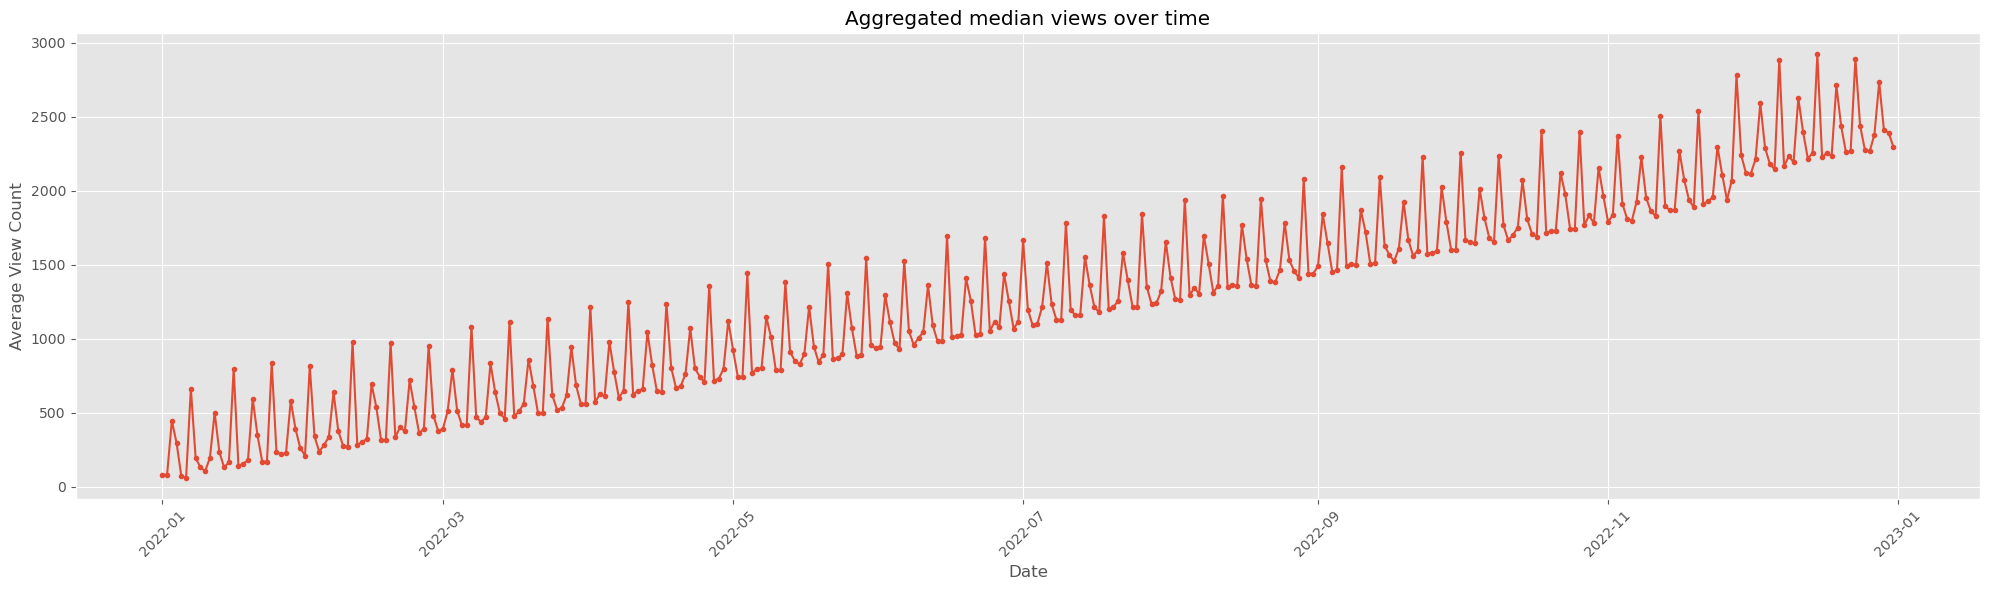

In [224]:
aggregated_df = final_dataset.resample('D').mean()

# Plotting aggregated view_count over time
plt.figure(figsize=(20, 6))
plt.plot(aggregated_df.index, aggregated_df['view_count'], marker='.')
plt.title('Aggregated median views over time')
plt.xlabel('Date')
plt.ylabel('Average View Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<AxesSubplot: xlabel='date'>

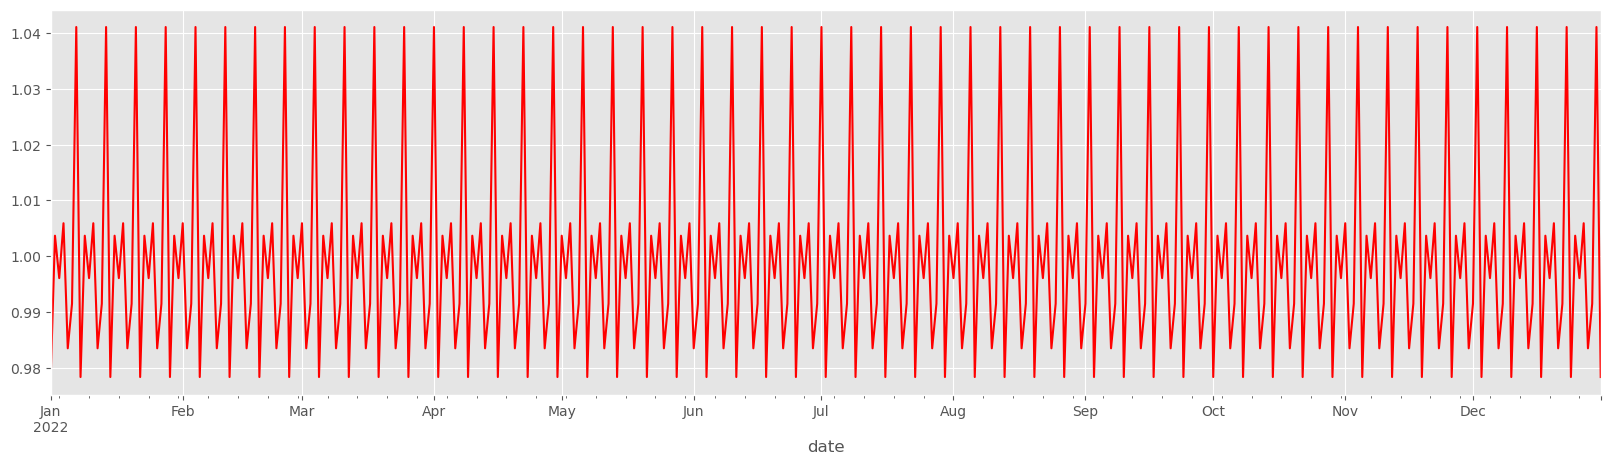

In [225]:
seasonals = seasonal_decompose(aggregated_df['view_count'], period=7, model='multiplicative')
seasonals.seasonal.plot(color='red', figsize=(20, 5))


<AxesSubplot: xlabel='date'>

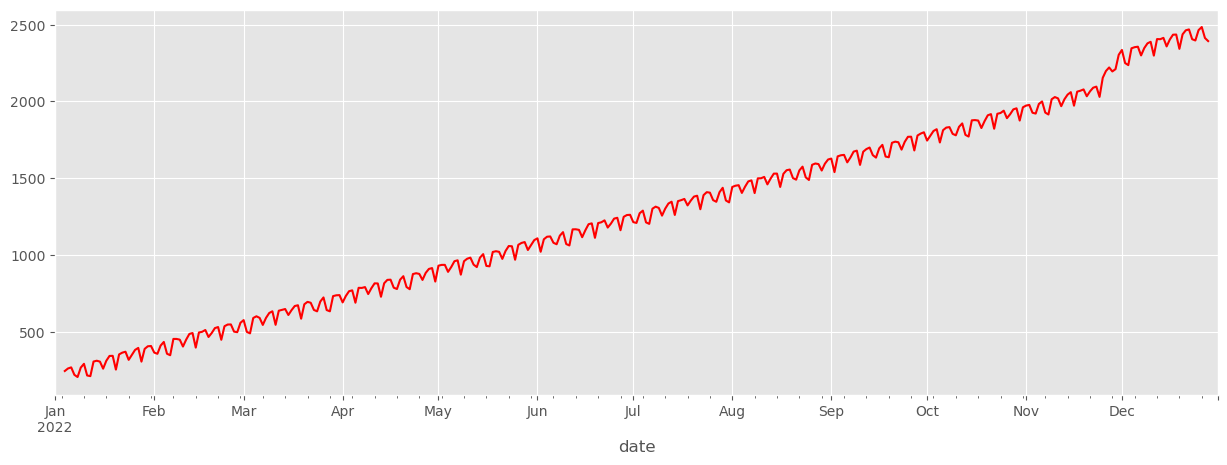

In [226]:
seasonals.trend.plot(color='red', figsize=(15, 5))

Text(0.5, 1.05, 'Views Time-Series Decomposition')

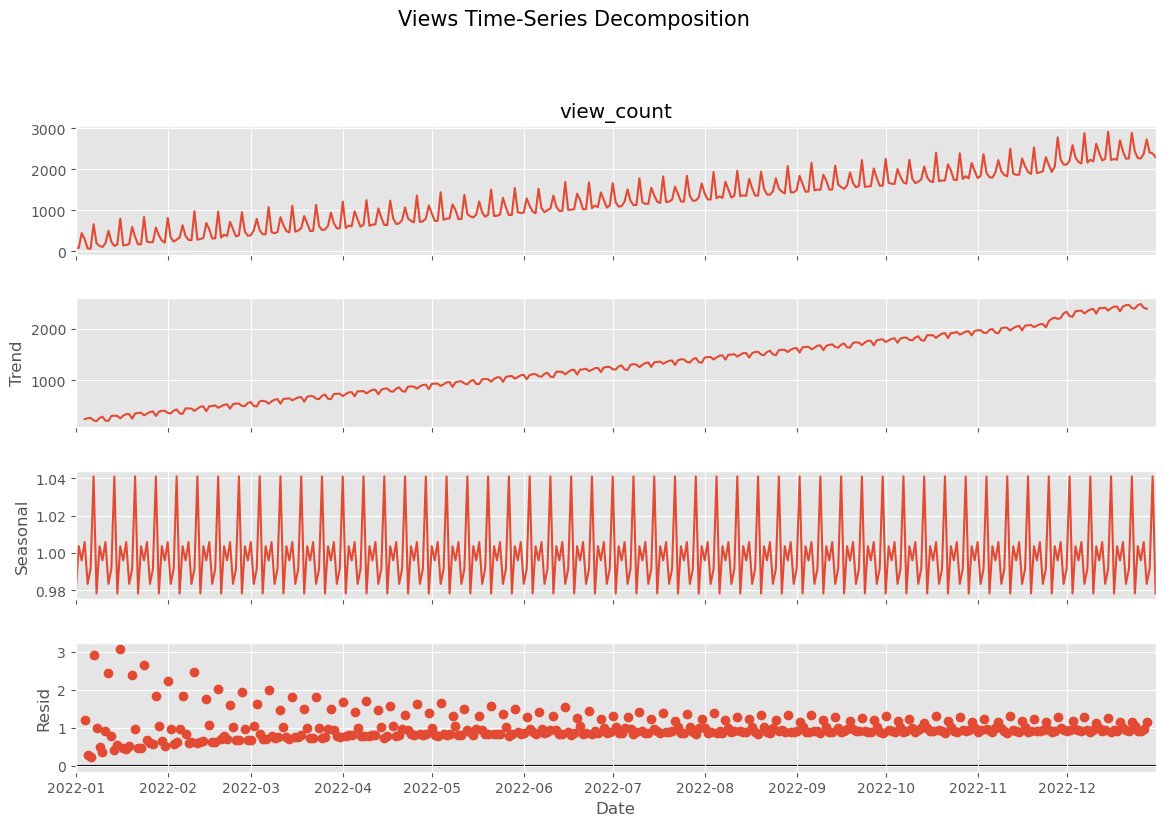

In [227]:
figure = seasonals.plot()
figure.set_figwidth(12)
figure.set_figheight(8)
plt.xlabel("Date", fontsize=12)
plt.suptitle(
    "Views Time-Series Decomposition",  # Text of title
    y=1.05,  # Position of title
    size=15,  # Size of title
)

In [228]:
final_dataset.head()

,segment_id,view_count,windows,android,mac os x,iphone,other,segment_name,day_of_week,day_of_month,month,hour
date,,,,,,,,,,,,
2022-01-01 00:00:00,379,177,120,7,37,9,2,Technology & Computing,5,1,1,0
2022-01-01 01:00:00,379,135,92,5,28,7,1,Technology & Computing,5,1,1,1
2022-01-01 02:00:00,379,26,18,1,5,1,0,Technology & Computing,5,1,1,2
2022-01-01 03:00:00,379,159,108,6,33,8,2,Technology & Computing,5,1,1,3
2022-01-01 04:00:00,379,50,34,2,10,2,0,Technology & Computing,5,1,1,4


In [229]:
final_dataset[['windows', 'android', 'mac os x', 'iphone',  'other']].describe()

,windows,android,mac os x,iphone,other
count,95526.000000,95526.000000,95526.000000,95526.000000,95526.000000
mean,865.168980,47.649195,261.582690,60.476582,13.617277
std,1036.010017,59.390485,309.851444,74.242968,15.030967
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,141.000000,8.000000,58.000000,12.000000,3.000000
50%,445.000000,20.000000,120.000000,25.000000,8.000000
75%,1351.000000,72.000000,397.000000,92.000000,21.000000
max,10855.000000,639.000000,3352.000000,798.000000,160.000000


In [230]:
tech_computing = final_dataset[final_dataset['segment_name'] == 'Technology & Computing']
tech_computing.head()

,segment_id,view_count,windows,android,mac os x,iphone,other,segment_name,day_of_week,day_of_month,month,hour
date,,,,,,,,,,,,
2022-01-01 00:00:00,379,177,120,7,37,9,2,Technology & Computing,5,1,1,0
2022-01-01 01:00:00,379,135,92,5,28,7,1,Technology & Computing,5,1,1,1
2022-01-01 02:00:00,379,26,18,1,5,1,0,Technology & Computing,5,1,1,2
2022-01-01 03:00:00,379,159,108,6,33,8,2,Technology & Computing,5,1,1,3
2022-01-01 04:00:00,379,50,34,2,10,2,0,Technology & Computing,5,1,1,4


In [231]:
resampled_df = final_dataset.resample('D').mean()


/var/folders/q4/xxffn3rn1mq08t7xhtm9_fbw0000gn/T/ipykernel_5129/1666489083.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = final_dataset.resample('D').mean()


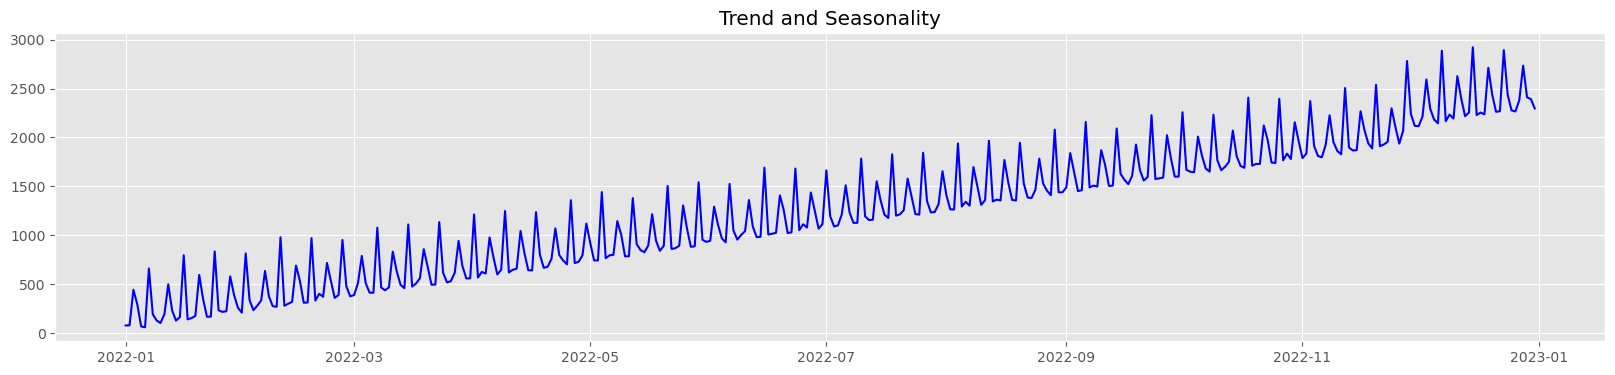

In [232]:

def plot_df(df, x, y, title="", xlabel="", ylabel="", dpi=100):
    plt.figure(figsize=(20, 4), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(resampled_df, x=resampled_df.index, y=resampled_df['view_count'], title='Trend and Seasonality')

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

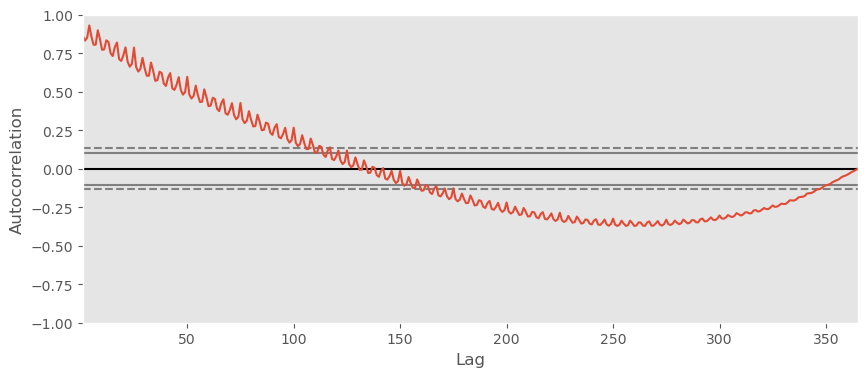

In [233]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':100})
autocorrelation_plot(resampled_df['view_count'].tolist())

In [234]:
final_dataset.head()

,segment_id,view_count,windows,android,mac os x,iphone,other,segment_name,day_of_week,day_of_month,month,hour
date,,,,,,,,,,,,
2022-01-01 00:00:00,379,177,120,7,37,9,2,Technology & Computing,5,1,1,0
2022-01-01 01:00:00,379,135,92,5,28,7,1,Technology & Computing,5,1,1,1
2022-01-01 02:00:00,379,26,18,1,5,1,0,Technology & Computing,5,1,1,2
2022-01-01 03:00:00,379,159,108,6,33,8,2,Technology & Computing,5,1,1,3
2022-01-01 04:00:00,379,50,34,2,10,2,0,Technology & Computing,5,1,1,4


In [235]:
final_dataset.dtypes

segment_id       int64
view_count       int64
windows          int64
android          int64
mac os x         int64
iphone           int64
other            int64
segment_name    object
day_of_week      int64
day_of_month     int64
month            int64
hour             int64
dtype: object

In [236]:
final_dataset.head()

,segment_id,view_count,windows,android,mac os x,iphone,other,segment_name,day_of_week,day_of_month,month,hour
date,,,,,,,,,,,,
2022-01-01 00:00:00,379,177,120,7,37,9,2,Technology & Computing,5,1,1,0
2022-01-01 01:00:00,379,135,92,5,28,7,1,Technology & Computing,5,1,1,1
2022-01-01 02:00:00,379,26,18,1,5,1,0,Technology & Computing,5,1,1,2
2022-01-01 03:00:00,379,159,108,6,33,8,2,Technology & Computing,5,1,1,3
2022-01-01 04:00:00,379,50,34,2,10,2,0,Technology & Computing,5,1,1,4


In [237]:
df = final_dataset['view_count']
resampled_df = df.resample('D').mean()
df_subset1 = resampled_df['2022-01-01 00:00:00': '2022-05-01 00:00:00']
df_subset2 = resampled_df['2022-05-02 00:00:00': '2022-12-31 00:00:00']

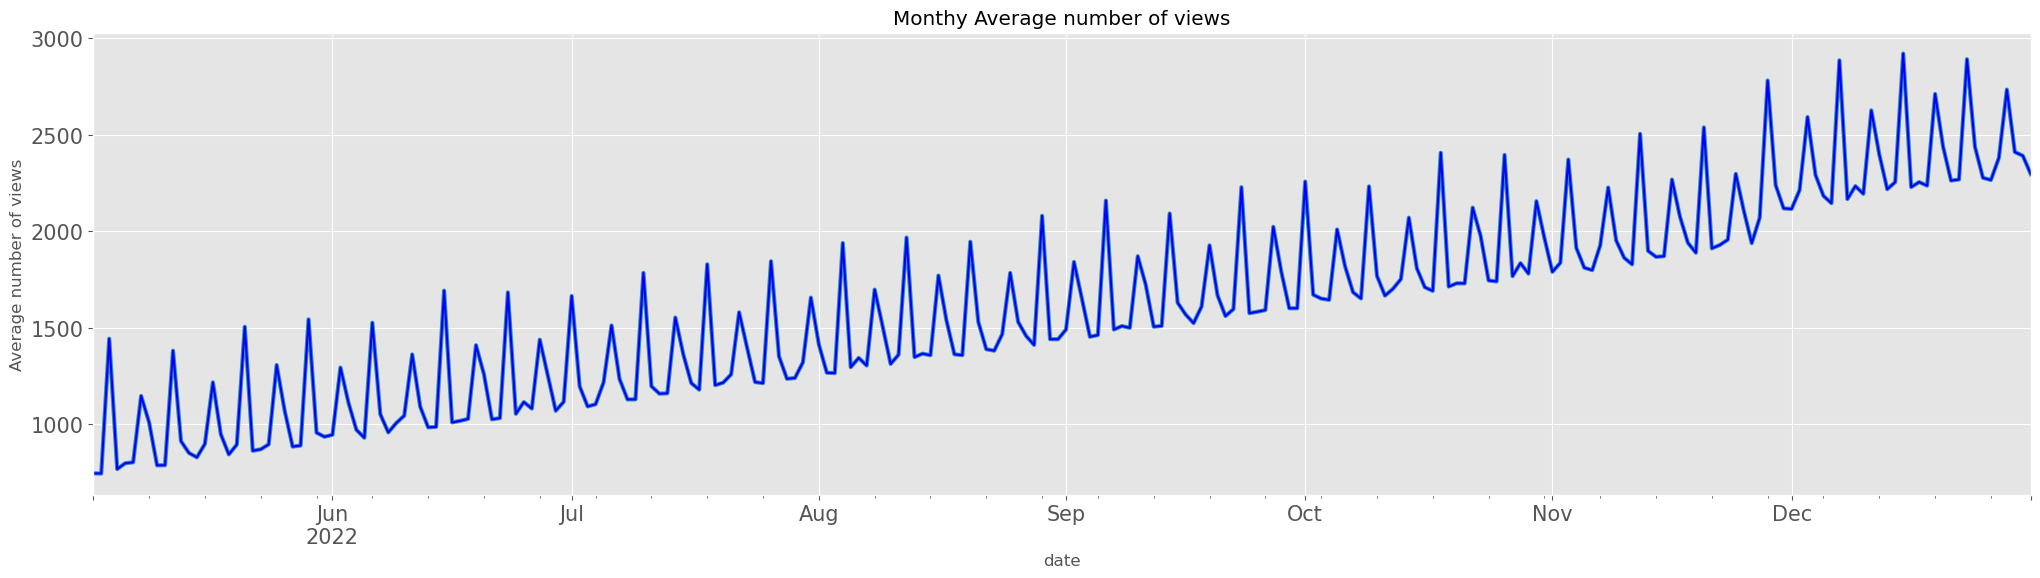

In [238]:
plt.style.use('ggplot')
df_subset2.plot()
ax = df_subset2.plot(figsize=(25, 6), fontsize=15, linewidth=3)
ax = df_subset2.plot(color='blue')
ax.set_label('Date')
ax.set_ylabel('Average number of views')
ax.set_title('Monthy Average number of views')
plt.show()

- Wyrazny trend wzrostowy ale tez sygnal okresowy.

In [239]:
latest_date = final_dataset.index.max()

print("Latest Date:", latest_date)

Latest Date: 2022-12-31 23:00:00


In [240]:
import statsmodels.api as sm

In [241]:
decomposition = sm.tsa.seasonal_decompose(resampled_df)
trend = decomposition.trend
seasonal = decomposition.seasonal
print(decomposition.seasonal)  # trend = decm.trend , seasonal = dec.seasonal

date
2022-01-01   -3.071575
2022-01-02   -1.772926
2022-01-03   -1.978060
2022-01-04    0.367570
2022-01-05    2.913341
                ...   
2022-12-27    0.367570
2022-12-28    2.913341
2022-12-29   -5.153889
2022-12-30    8.695539
2022-12-31   -3.071575
Freq: D, Name: seasonal, Length: 365, dtype: float64


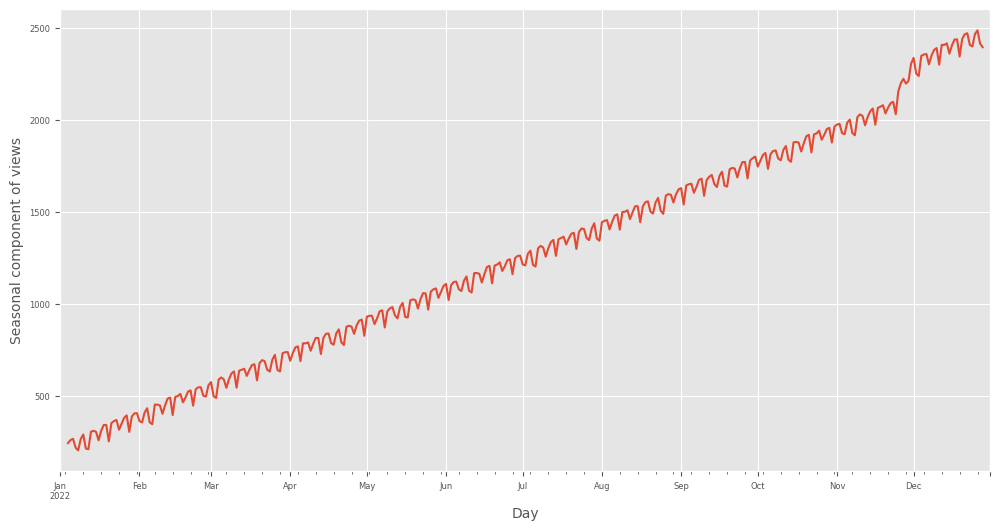

In [242]:
trend = decomposition.trend
ax = trend.plot(figsize=(12, 6), fontsize=6)
ax.set_xlabel('Day', fontsize=10)
ax.set_ylabel('Seasonal component of views', fontsize=10)
plt.show()
    

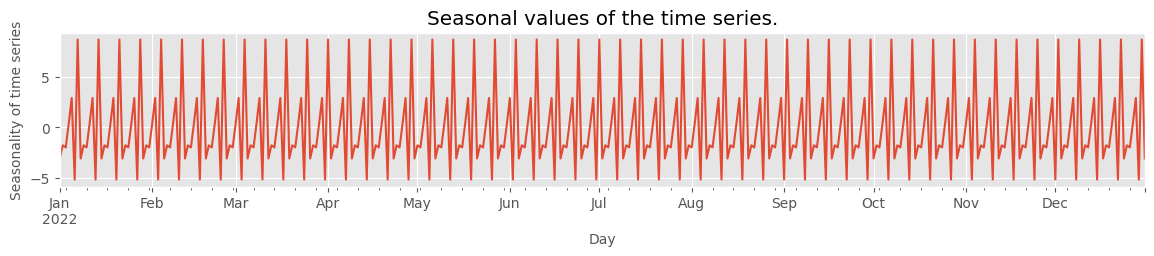

In [243]:
decmp_seasonal = decomposition.seasonal
ax = decmp_seasonal.plot(figsize=(14, 2))
ax.set_xlabel('Day', fontsize=10)
ax.set_ylabel('Seasonality of time series', fontsize=10)
ax.set_title('Seasonal values of the time series.')
plt.show()

In [244]:
final_dataset.head()

,segment_id,view_count,windows,android,mac os x,iphone,other,segment_name,day_of_week,day_of_month,month,hour
date,,,,,,,,,,,,
2022-01-01 00:00:00,379,177,120,7,37,9,2,Technology & Computing,5,1,1,0
2022-01-01 01:00:00,379,135,92,5,28,7,1,Technology & Computing,5,1,1,1
2022-01-01 02:00:00,379,26,18,1,5,1,0,Technology & Computing,5,1,1,2
2022-01-01 03:00:00,379,159,108,6,33,8,2,Technology & Computing,5,1,1,3
2022-01-01 04:00:00,379,50,34,2,10,2,0,Technology & Computing,5,1,1,4


In [245]:
final_dataset.head()
count_dataset = final_dataset[['view_count']]

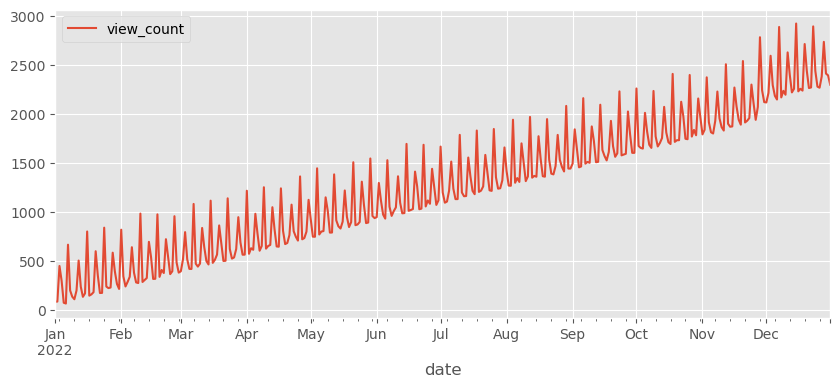

In [246]:
data_monthly = count_dataset.resample('d').mean() # assuming daily seasonality
data_monthly.plot()
plt.show()

- decomposing

In [247]:
decomposition = seasonal_decompose(data_monthly, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
print(decomposition.trend)
print(decomposition.seasonal)
print(decomposition.resid)


date
2022-01-01            NaN
2022-01-02            NaN
2022-01-03            NaN
2022-01-04     243.406926
2022-01-05     259.871212
                 ...     
2022-12-27    2413.498214
2022-12-28    2393.329167
2022-12-29            NaN
2022-12-30            NaN
2022-12-31            NaN
Freq: D, Name: trend, Length: 365, dtype: float64
date
2022-01-01    0.978344
2022-01-02    1.003662
2022-01-03    0.996066
2022-01-04    1.005900
2022-01-05    0.983489
                ...   
2022-12-27    1.005900
2022-12-28    0.983489
2022-12-29    0.991486
2022-12-30    1.041053
2022-12-31    0.978344
Freq: D, Name: seasonal, Length: 365, dtype: float64
date
2022-01-01         NaN
2022-01-02         NaN
2022-01-03         NaN
2022-01-04    1.209015
2022-01-05    0.277977
                ...   
2022-12-27    0.980450
2022-12-28    1.161387
2022-12-29         NaN
2022-12-30         NaN
2022-12-31         NaN
Freq: D, Name: resid, Length: 365, dtype: float64


In [248]:
mean_views_per_month = final_dataset.groupby('month')['view_count'].mean().reset_index()

In [249]:
mean_views_per_month

,month,view_count
0,1,287.253543
1,2,473.095373
2,3,623.124389
3,4,819.301894
4,5,982.165934
5,6,1151.280429
6,7,1336.787390
7,8,1504.008431
8,9,1677.551136
9,10,1865.885142


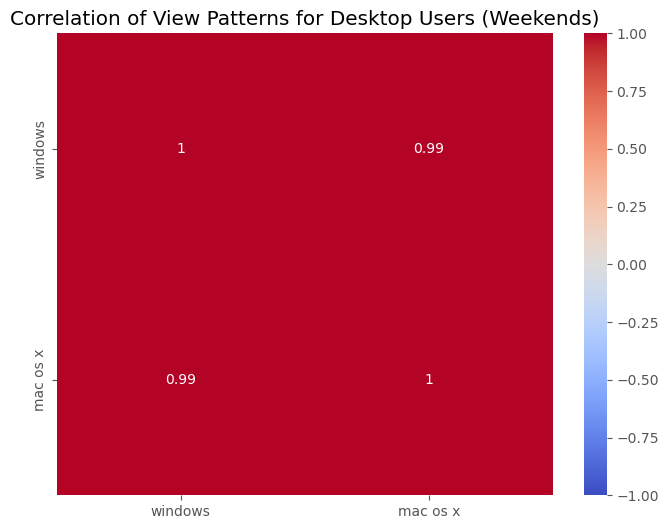

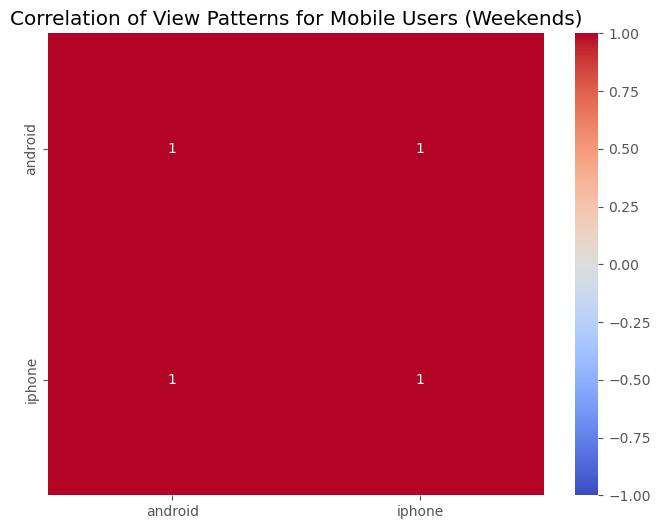

In [250]:
desktop_corr = final_dataset[['windows', 'mac os x']].corr()

# Calculates correlation coefficients between segments for Mobile users
mobile_corr =final_dataset[['android', 'iphone']].corr()

# Creates a heatmap for Desktop correlations
plt.figure(figsize=(8, 6))
sns.heatmap(desktop_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation of View Patterns for Desktop Users (Weekends)")
plt.show()

# Creates a heatmap for Mobile correlations
plt.figure(figsize=(8, 6))
sns.heatmap(mobile_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation of View Patterns for Mobile Users (Weekends)")
plt.show()

2. Positive correlation beteween desktop views and mobile views patterns, gives as also an information about a very strong linear relationship between these two variables.  

 For example, if a user from segment covers widely interesting topics such a Technology & Computing, users are more likely to engage with it regardless of device.Some user behaviors, such as checking news or social media updates during weekends, might be consistent across devices, leading to similar view patterns. Effective cross-platform promotion can result in similar viewing patterns. Users from both platforms are more likely to engage with a segment that is promoted consistently and effectively across both desktop and mobile platforms.
